In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import numpy as np

import missingno as msno
import seaborn as sns
#import jpx_tokyo_market_prediction
import lightgbm as lgb

In [3]:
TRAIN_DATA_PATH = '/Users/bearmac/Projects/Kaggle/JPX_Tokyo_Exchange_Prediction/data/train_files'
SAMPLE_SUBMISSION_PATH = '/Users/bearmac/Projects/Kaggle/JPX_Tokyo_Exchange_Prediction/data/example_test_files/submission.csv'

In [8]:
def get_data(path, file):
    csv_path = os.path.join(path, file)
    return pd.read_csv(csv_path)

# Quick look at the data structure of stock_prices.csv

In [75]:
train_stock_prices = get_data(TRAIN_DATA_PATH, 'stock_prices.csv')
train_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,"2,734.00","2,755.00","2,730.00","2,742.00",31400,1.00,NaN,False,0.00
1,20170104_1332,2017-01-04,1332,568.00,576.00,563.00,571.00,2798500,1.00,NaN,False,0.01
2,20170104_1333,2017-01-04,1333,"3,150.00","3,210.00","3,140.00","3,210.00",270800,1.00,NaN,False,0.01
3,20170104_1376,2017-01-04,1376,"1,510.00","1,550.00","1,510.00","1,550.00",11300,1.00,NaN,False,0.01
4,20170104_1377,2017-01-04,1377,"3,270.00","3,350.00","3,270.00","3,330.00",150800,1.00,NaN,False,0.00


In [12]:
train_stock_prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   RowId             2332531 non-null  object 
 1   Date              2332531 non-null  object 
 2   SecuritiesCode    2332531 non-null  int64  
 3   Open              2324923 non-null  float64
 4   High              2324923 non-null  float64
 5   Low               2324923 non-null  float64
 6   Close             2324923 non-null  float64
 7   Volume            2332531 non-null  int64  
 8   AdjustmentFactor  2332531 non-null  float64
 9   ExpectedDividend  18865 non-null    float64
 10  SupervisionFlag   2332531 non-null  bool   
 11  Target            2332293 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [23]:
pd.options.display.float_format = '{:,.2f}'.format
train_stock_prices.drop('SecuritiesCode', axis=1).describe()

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,"2,324,923.00","2,324,923.00","2,324,923.00","2,324,923.00","2,332,531.00","2,332,531.00","18,865.00","2,332,293.00"
mean,"2,594.51","2,626.54","2,561.23","2,594.02","691,936.56",1.00,22.02,0.00
std,"3,577.19","3,619.36","3,533.49","3,576.54","3,911,255.94",0.07,29.88,0.02
min,14.00,15.00,13.00,14.00,0.00,0.10,0.00,-0.58
25%,"1,022.00","1,035.00","1,009.00","1,022.00","30,300.00",1.00,5.00,-0.01
50%,"1,812.00","1,834.00","1,790.00","1,811.00","107,100.00",1.00,15.00,0.00
75%,"3,030.00","3,070.00","2,995.00","3,030.00","402,100.00",1.00,30.00,0.01
max,"109,950.00","110,500.00","107,200.00","109,550.00","643,654,000.00",20.00,"1,070.00",1.12


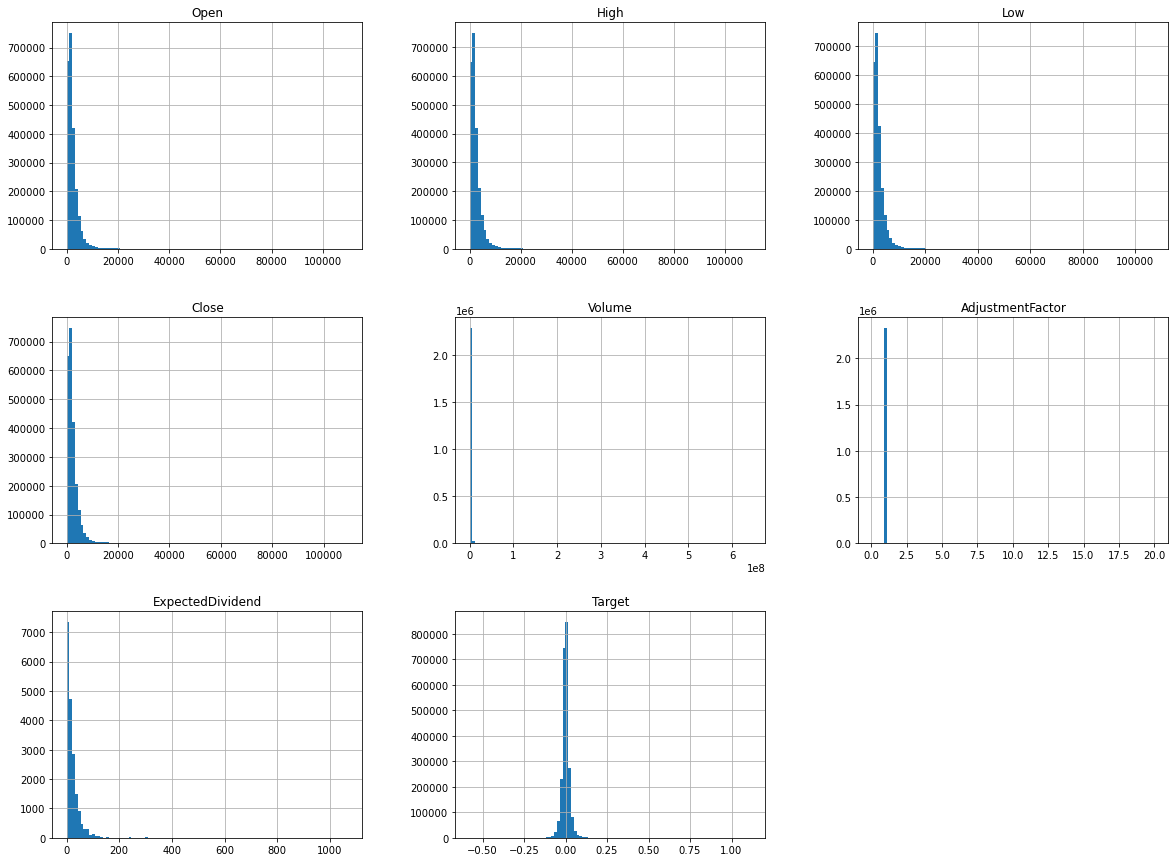

In [24]:
train_stock_prices.drop('SecuritiesCode', axis=1).hist(bins=100, figsize=(20,15))
plt.show()

# Findings:
- Target has very low variance, most value are very close to 0
- AdjustmentFactor needs to be taken into account when looking at Target and Close
- The prices are not normally distributed. Does that create a problem?

## Adjustment factor implementation

In [30]:
train_stock_prices[train_stock_prices['AdjustmentFactor']!=1].head(1)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
16052,20170117_6861,2017-01-17,6861,"83,610.00","83,610.00","82,540.00","82,600.00",146400,0.50,NaN,False,0.01


In [35]:
sec_6861 = train_stock_prices[train_stock_prices['SecuritiesCode']==6861]
sec_6861_j17 = sec_6861[sec_6861['Date']>='2017-01-17'] # && (sec_6861['Date']=='2017-01-18')]
sec_6861_j17

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
16052,20170117_6861,2017-01-17,6861,"83,610.00","83,610.00","82,540.00","82,600.00",146400,0.50,NaN,False,0.01
17917,20170118_6861,2017-01-18,6861,"41,660.00","41,660.00","40,500.00","40,920.00",316800,1.00,NaN,False,0.00
19782,20170119_6861,2017-01-19,6861,"41,540.00","41,550.00","41,010.00","41,190.00",267500,1.00,NaN,False,0.02
21647,20170120_6861,2017-01-20,6861,"41,310.00","41,620.00","41,050.00","41,200.00",282000,1.00,NaN,False,0.02
23512,20170123_6861,2017-01-23,6861,"41,200.00","42,210.00","41,120.00","42,010.00",482800,1.00,NaN,False,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
2323751,20211129_6861,2021-11-29,6861,"69,550.00","72,030.00","69,400.00","70,720.00",516100,1.00,NaN,False,0.00
2325751,20211130_6861,2021-11-30,6861,"72,160.00","72,680.00","70,150.00","70,330.00",778900,1.00,NaN,False,0.01
2327751,20211201_6861,2021-12-01,6861,"71,810.00","72,180.00","70,460.00","70,460.00",506900,1.00,NaN,False,0.00
2329751,20211202_6861,2021-12-02,6861,"70,470.00","71,110.00","70,250.00","70,960.00",429600,1.00,NaN,False,-0.00


In [84]:
%%time
a = train_stock_prices.groupby(['SecuritiesCode'])['AdjustmentFactor'].expanding(1).apply(np.prod)

CPU times: user 1min 33s, sys: 231 ms, total: 1min 33s
Wall time: 1min 33s


SecuritiesCode         
1301            0         1.00
                1865      1.00
                3730      1.00
                5595      1.00
                7460      1.00
                          ... 
9997            2324530   1.00
                2326530   1.00
                2328530   1.00
                2330530   1.00
                2332530   1.00
Name: AdjustmentFactor, Length: 2332531, dtype: float64

In [74]:
#e = stock_prices[stock_prices.AdjustmentFactor != 1].set_index('Date').groupby(
#    ['SecuritiesCode'])['AdjustmentFactor'].expanding(1).apply(np.prod)
#e.name = 'CumFactor'
#final2 = stock_prices.merge(e, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final2['CumFactor'] = final2.sort_values(by='Date').groupby(['SecuritiesCode'])['CumFactor'].fillna(method='ffill')
#final2['CumFactor'] = final2['CumFactor'].fillna(1)
%%time
e = sec_6861['AdjustmentFactor'].expanding(1).apply(np.prod)
f = train_stock_prices[train_stock_prices['SecuritiesCode']==1301][
        'AdjustmentFactor'].expanding(1).apply(np.prod)
g = pd.concat([e,f])
e.shift(1).fillna(1)

CPU times: user 141 ms, sys: 11.4 ms, total: 152 ms
Wall time: 149 ms


1132      1.00
2997      1.00
4862      1.00
6727      1.00
8592      1.00
          ... 
2323751   0.25
2325751   0.25
2327751   0.25
2329751   0.25
2331751   0.25
Name: AdjustmentFactor, Length: 1202, dtype: float64

In [78]:
%%time
def gen_adjusted_series(df, code):
    #generate a series with original index and cumulative factor for one SecuritiesCode
    #input: a df (most likely train_stock_prices) and a SecuritiesCode
    return df[df['SecuritiesCode']==code]['AdjustmentFactor'].expanding(1).apply(np.prod).shift(1).fillna(1)



def adjusted_df(df):
    all_codes = df['SecuritiesCode'].unique()
    cumulative_adj = gen_adjusted_series(df, all_codes[0])
    
    for sec_code in all_codes[1:]:
        new_adj = gen_adjusted_series(df, sec_code)
        cumulative_adj = pd.concat([cumulative_adj, new_adj])
        
    df['Cumulative_Factor'] = cumulative_adj
    return df
    
train_SP_adj = adjusted_df(train_stock_prices)
train_SP_adj

CPU times: user 1min 45s, sys: 5 s, total: 1min 50s
Wall time: 1min 44s


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Cumulative_Factor
0,20170104_1301,2017-01-04,1301,"2,734.00","2,755.00","2,730.00","2,742.00",31400,1.00,NaN,False,0.00,1.00
1,20170104_1332,2017-01-04,1332,568.00,576.00,563.00,571.00,2798500,1.00,NaN,False,0.01,1.00
2,20170104_1333,2017-01-04,1333,"3,150.00","3,210.00","3,140.00","3,210.00",270800,1.00,NaN,False,0.01,1.00
3,20170104_1376,2017-01-04,1376,"1,510.00","1,550.00","1,510.00","1,550.00",11300,1.00,NaN,False,0.01,1.00
4,20170104_1377,2017-01-04,1377,"3,270.00","3,350.00","3,270.00","3,330.00",150800,1.00,NaN,False,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.00,528.00,513.00,528.00,44200,1.00,NaN,False,0.03,1.00
2332527,20211203_9991,2021-12-03,9991,782.00,794.00,782.00,794.00,35900,1.00,NaN,False,0.03,1.00
2332528,20211203_9993,2021-12-03,9993,"1,690.00","1,690.00","1,645.00","1,645.00",7200,1.00,NaN,False,-0.00,1.00
2332529,20211203_9994,2021-12-03,9994,"2,388.00","2,396.00","2,380.00","2,389.00",6500,1.00,NaN,False,0.01,1.00


In [77]:
train_stock_prices[(train_stock_prices['SecuritiesCode']==6861) & (train_stock_prices['AdjustmentFactor']!=1)]
dates = ['2017-01-16', '2017-01-17', '2017-01-18', '2019-11-17','2019-11-18', '2019-11-19']
train_stock_prices[(train_stock_prices['SecuritiesCode']==6861) & (train_stock_prices['Date'].isin(dates))]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Cumulative_Factor
14187,20170116_6861,2017-01-16,6861,"83,900.00","84,630.00","83,600.00","83,610.00",232000,1.00,NaN,False,-0.01,1.00
16052,20170117_6861,2017-01-17,6861,"83,610.00","83,610.00","82,540.00","82,600.00",146400,0.50,NaN,False,0.01,1.00
17917,20170118_6861,2017-01-18,6861,"41,660.00","41,660.00","40,500.00","40,920.00",316800,1.00,NaN,False,0.00,0.50
1340160,20191118_6861,2019-11-18,6861,"74,020.00","74,270.00","73,550.00","74,220.00",187300,0.50,NaN,False,0.00,0.50
1342115,20191119_6861,2019-11-19,6861,"37,100.00","37,100.00","36,510.00","36,560.00",386500,1.00,NaN,False,0.00,0.25


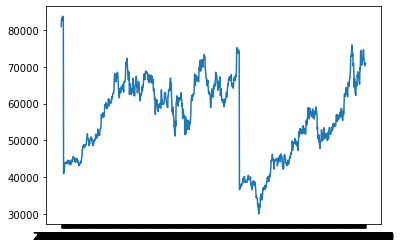

In [70]:
sec_6861 = train_stock_prices[train_stock_prices['SecuritiesCode']==6861]
plt.plot(sec_6861['Date'], sec_6861['Close'])

# Previous version

In [2]:
%%time
#Import from stock_prices.csv and parse columns with dates:
stock_prices = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv',
                           index_col=0, parse_dates=[1])

CPU times: user 5.46 s, sys: 545 ms, total: 6 s
Wall time: 7.68 s


In [3]:
stock_prices.sample(5)

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
RowId,,,,,,,,,,,
20170802_6035,2017-08-02,6035,1320.0,1396.0,1320.0,1378.0,29700,1.0,NaN,False,0.059463
20170411_4956,2017-04-11,4956,1318.0,1325.0,1316.0,1317.0,38700,1.0,NaN,False,-0.006140
20180410_4666,2018-04-10,4666,2985.0,2998.0,2942.0,2945.0,869600,1.0,NaN,False,0.004808
20210616_5707,2021-06-16,5707,1967.0,1985.0,1931.0,1943.0,246100,1.0,NaN,False,-0.032055
20170517_8362,2017-05-17,8362,288.0,289.0,285.0,288.0,146000,1.0,NaN,False,0.003521


In [4]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2332531 entries, 20170104_1301 to 20211203_9997
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Date              datetime64[ns]
 1   SecuritiesCode    int64         
 2   Open              float64       
 3   High              float64       
 4   Low               float64       
 5   Close             float64       
 6   Volume            int64         
 7   AdjustmentFactor  float64       
 8   ExpectedDividend  float64       
 9   SupervisionFlag   bool          
 10  Target            float64       
dtypes: bool(1), datetime64[ns](1), float64(7), int64(2)
memory usage: 198.0+ MB


In [5]:
%%time
stock_prices.dropna(inplace=True, subset=['Open','High','Low','Close','Target'])

CPU times: user 184 ms, sys: 31.9 ms, total: 216 ms
Wall time: 217 ms


In [6]:
#Это бесполезные операции, сначала генерирурю список дней и акций, а потом джойном удаляю строки, для которых нет данных в stock_prices
#Просто потренировался, можно сразу брать индексы из stock_prices
#date_range = pd.date_range(stock_prices.Date.min(), stock_prices.Date.max(), freq='D')
#dates = np.array(date_range)
#stocks = np.array(stock_list_incl.index)
#multi_index = pd.MultiIndex.from_product([dates, stocks], names=['Date','SecuritiesCode'])
#final_full = multi_index.to_frame(index = False)
#final1 = final_full.merge(stock_prices.iloc[:,:], how='inner', on=['Date','SecuritiesCode'])
#potenitial to make more efficient - adding the one-hot encoding of the days of the week
#final1 = stock_prices
#final1['AdjustmentFactor'] = stock_prices.sort_values(by='Date').groupby('SecuritiesCode')['AdjustmentFactor'].shift(1)
#final1['AdjustmentFactor'] = final1.sort_values(by='Date').groupby('SecuritiesCode')['AdjustmentFactor'].bfill()
#final1['DoW'] = [i.weekday() for i in final1['Date']]
#one_hot = pd.get_dummies(final1['DoW'])
#final1 = final1.drop('DoW',axis = 1)
#final1 = final1.join(one_hot)
#final1 = final1.rename(columns={0: 'Mo',1: 'Tu',2: 'We',3: 'Th',4: 'Fr'})
#final1[(final1.SecuritiesCode == 2590) & (final1.Date < '2017-02-01')]
#final1['day'] = final1['Date'].dt.dayofweek
def day_of_week(df):
    df['Day_of_week'] = df['Date'].dt.dayofweek
    return df

In [79]:
#Магия
#e = stock_prices[stock_prices.AdjustmentFactor != 1].set_index('Date').groupby(
#    ['SecuritiesCode'])['AdjustmentFactor'].expanding(1).apply(np.prod)
#e.name = 'CumFactor'
#final2 = stock_prices.merge(e, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final2['CumFactor'] = final2.sort_values(by='Date').groupby(['SecuritiesCode'])['CumFactor'].fillna(method='ffill')
#final2['CumFactor'] = final2['CumFactor'].fillna(1)
#final2['Open'] = final2['Open'] / final2['CumFactor']
#final2['High'] = final2['High'] / final2['CumFactor']
#final2['Low'] = final2['Low'] / final2['CumFactor']
#final2['Close'] = final2['Close'] / final2['CumFactor']
#final2['Volume'] = final2['Volume'] * final2['CumFactor']
#final2['ExpectedDividend'] = (final2['ExpectedDividend'] / final2['CumFactor'])
#final2['DividendRatio'] = final2['ExpectedDividend'] / final2['Close']
#final2['DividendRatio'] = final2['DividendRatio'].fillna(0)
#Вопрос: в чистом виде модель всегда будет советовать вставать в шорт перед экс-дивидендой датой, в реальной жизни это не имеет смысла
#так как либо это запрещено, либо с шортящих вычтут сумму дивидендов, но формула оценки модели этого не учитывает
#можно либо пользоваться этой дырой, либо из target вычитать DividendRatio, то есть если цена упадет больше чем на сумму дивидендов
#то мы окажемся в плюсе
#print(final2[(final2.SecuritiesCode==3421) & (final2.Date < '2017-02-01')])
def cumulative_adj_factor(df):
    e = df[df.AdjustmentFactor != 1].set_index('Date').groupby(
    ['SecuritiesCode'])['AdjustmentFactor'].expanding(1).apply(np.prod)
    e.name = 'CumFactor'
    out_df = df.merge(e, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
    out_df['CumFactor'] = out_df['CumFactor'].fillna(1)
    out_df['Open'] = out_df['Open'] / out_df['CumFactor']
    out_df['High'] = out_df['High'] / out_df['CumFactor']
    out_df['Low'] = out_df['Low'] / out_df['CumFactor']
    out_df['Close'] = out_df['Close'] / out_df['CumFactor']
    out_df['Volume'] = out_df['Volume'] * out_df['CumFactor']
    out_df['ExpectedDividend'] = (out_df['ExpectedDividend'] / out_df['CumFactor'])
    out_df['DividendRatio'] = out_df['ExpectedDividend'] / out_df['Close']
    out_df['DividendRatio'] = out_df['DividendRatio'].fillna(0)
    out_df = out_df.drop(['CumFactor', 'AdjustmentFactor'],axis=1)
    
    return out_df

In [81]:
%%time
test = cumulative_adj_factor(train_stock_prices)
test

CPU times: user 684 ms, sys: 528 ms, total: 1.21 s
Wall time: 1.29 s


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,ExpectedDividend,SupervisionFlag,Target,Cumulative_Factor,DividendRatio
0,20170104_1301,2017-01-04,1301,"2,734.00","2,755.00","2,730.00","2,742.00","31,400.00",NaN,False,0.00,1.00,0.00
1,20170104_1332,2017-01-04,1332,568.00,576.00,563.00,571.00,"2,798,500.00",NaN,False,0.01,1.00,0.00
2,20170104_1333,2017-01-04,1333,"3,150.00","3,210.00","3,140.00","3,210.00","270,800.00",NaN,False,0.01,1.00,0.00
3,20170104_1376,2017-01-04,1376,"1,510.00","1,550.00","1,510.00","1,550.00","11,300.00",NaN,False,0.01,1.00,0.00
4,20170104_1377,2017-01-04,1377,"3,270.00","3,350.00","3,270.00","3,330.00","150,800.00",NaN,False,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.00,528.00,513.00,528.00,"44,200.00",NaN,False,0.03,1.00,0.00
2332527,20211203_9991,2021-12-03,9991,782.00,794.00,782.00,794.00,"35,900.00",NaN,False,0.03,1.00,0.00
2332528,20211203_9993,2021-12-03,9993,"1,690.00","1,690.00","1,645.00","1,645.00","7,200.00",NaN,False,-0.00,1.00,0.00
2332529,20211203_9994,2021-12-03,9994,"2,388.00","2,396.00","2,380.00","2,389.00","6,500.00",NaN,False,0.01,1.00,0.00


In [8]:
#Скользящее среднее за 50 дней
#sma50 = final2.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=50,min_periods=1).mean()
#sma50.name = 'SMA50'
#final3 = final2.merge(sma50, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#Скользящее среднее за 10 дней
#sma10 = final3.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=10,min_periods=1).mean()
#sma10.name = 'SMA10'
#final4 = final3.merge(sma10, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#Относительная разница цен закрытия и скользящих средних
#final4['SMA50_Close_diff'] = (final4.Close-final4.SMA50) / final4.Close
#final4['SMA10_Close_diff'] = (final4.Close-final4.SMA10) / final4.Close
#final4
def moving_average(df, win):
    sma = df.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=win,min_periods=1).mean()
    sma.name = 'Moving_average_' + str(win)
    out_df = df.merge(sma, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
    out_df['Diff_Close_MA' + str(win)] = (out_df['Close']-out_df['Moving_average_' + str(win)]) / out_df['Close']
    return out_df

In [9]:
%%time
#Доля объемов на акцию от общедневного объема торговли
#final4['USDVol'] = final4['Volume'] * final4['Close']
#temp1 = final4.groupby('Date').agg('sum')['USDVol']
#final4 = final4.rename(columns={'USDVol': 'ind_volume'})
#final5 = final4.merge(temp1, how='left', left_on='Date', right_index=True)
#final5 = final5.rename(columns={'USDVol': 'tot_volume'})
#final5['Volume_share'] = final5['ind_volume'] / final5['tot_volume']
#final5
def volume_share(df):
    df['USDVol'] = df['Volume'] * df['Close']
    temp1 = df.groupby('Date').agg('sum')['USDVol']
    df = df.rename(columns={'USDVol': 'ind_volume'})
    df = df.merge(temp1, how='left', left_on='Date', right_index=True)
    df = df.rename(columns={'USDVol': 'tot_volume'})
    df['Volume_share'] = df['ind_volume'] / df['tot_volume']
    out_df = df.drop(['ind_volume', 'tot_volume'], axis=1)
    return out_df

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.6 µs


In [10]:
%%time
#Полосы Боллинджера:
#средняя линия уже есть, это SMA10
#верхняя линия: средняя линия + (10 * стандартное отклонение цен закрытия за 10 дней)
#нижняя линия: средняя линия - (10 * стандартное отклонение цен закрытия за 10 дней)
#sma10stdev = final5.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=10,min_periods=1).std()
#sma10stdev.name = 'SD10'
#final6 = final5.merge(sma10stdev, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
##final6['Upper_line'] = final6['SMA10'] + final6['SD10']
#final6['Lower_line'] = final6['SMA10'] - final6['SD10']
#относительная разница между ценой закрытия и нижней/верхней линиями
#final6['UL_Close-diff'] = (final6.Close-final6.Upper_line) / final6.Close
#final6['LL_Close-diff'] = (final6.Close-final6.Lower_line) / final6.Close
#final6
def bollinger(df, win=20, coef=3):
    sd_name = 'SD' + str(win)
    ma_name = 'Moving_average_' + str(win)
    stdev = df.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=win,min_periods=1).std()
    stdev.name = sd_name
    df = df.merge(stdev, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
    sma = df.set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=win,min_periods=1).mean()
    sma.name = ma_name
    out_df = df.merge(sma, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
    out_df['Upper_line'] = out_df[ma_name] + coef*out_df[sd_name]
    out_df['Lower_line'] = out_df[ma_name] - coef*out_df[sd_name]
    out_df['Bollinger_Close-Upper'] = (out_df['Close']-out_df['Upper_line']) / out_df['Close']
    out_df['Bollinger_Close-Lower'] = (out_df['Close']-out_df['Lower_line']) / out_df['Close']
    out_df = out_df.drop(['Upper_line', 'Lower_line'], axis=1)
    return out_df

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.1 µs


In [11]:
%%time
#RSI - to be checked and added later if necessary
#а) среднее значение последних 14 растущих дневных свечей
#б) среднее значение последних 14 падающих дневных свечей
#в) считаем RS: делим (а) на (б)
#г) считаем RSI: 100-(100/(1+RS))

#last14up = final6[final6["Close"] > final6["Open"]].set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=14, min_periods=1).mean()
#last14up.name = 'SMA14UP'
#final7 = final6.merge(last14up, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final7['SMA14UP'] = final7.sort_values(by='Date').groupby(['SecuritiesCode'])['SMA14UP'].fillna(method='ffill')
##last14down = final7[final7["Close"] < final7["Open"]].set_index('Date').groupby(['SecuritiesCode'])['Close'].rolling(window=14, min_periods=1).mean()
#last14down.name = 'SMA14DOWN'
#final8 = final7.merge(last14down, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final8['SMA14DOWN'] = final8.sort_values(by='Date').groupby(['SecuritiesCode'])['SMA14DOWN'].fillna(method='ffill')
#final8['RSI'] = (100-(100/(1+(final8.SMA14UP / final8.SMA14DOWN))))/100
#final8
#final8[final8.SecuritiesCode == 9993].tail(20)
#last14up[9993].tail(20)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [12]:
%%time
#Стохастический
#а) k = (цена закрытия - мин. цена дня)/(макс. цена дня - мин. цена дня)
#б) d = усредненная k за 3 дн
#теоретически возможно, что в знаменателе будет 0 три дня подряд и среднее не посчитается,
#на практике за 5 лет это не произошло ни разу, поэтому обрабатывать такое исключение не буду
#final8["k"] = (final8["Close"]-final8["Low"])/((final8["High"]-final8["Low"]))
#stohastic = final8.set_index('Date').groupby(['SecuritiesCode'])['k'].rolling(window=3, min_periods=1).mean()
#stohastic.name = 'Stochastic'
#final9 = final8.merge(stohastic, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final9.dropna(inplace=True, subset=['k'])
def stohastic(df, win=3):
    df["Weighted_Close-Low"] = (df["Close"]-df["Low"])/((df["High"]-df["Low"]))
    stohastic = df.set_index('Date').groupby(['SecuritiesCode'])['Weighted_Close-Low'].rolling(window=win, min_periods=1).mean()
    stohastic.name = 'Stochastic'
    out_df = df.merge(stohastic, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
    return out_df

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [13]:
%%time
#Ебанина- too complicated, to be added later
#Индикатор схождения-расхождения скользящих средних (MACD)
# а) Экспоненциальная скользящая средняя за 12 дней: EMA = Close * 2/(n+1) + EMA(prev) * (1–2/(n+1))
# б) Экспоненциальная скользящая средняя за 26 дней: EMA = Close * 2/(n+1) + EMA(prev) * (1–2/(n+1))
# в) MACD = ЕМА_12 − EMA_26
# г) Экспоненциальная скользящая средняя за 9 дней: EMA = MACD * 2/(n+1) + MACD(prev) * (1–2/(n+1))
# е) разница между EMA9 и MACD

#ema12 = final9.set_index('Date').groupby(['SecuritiesCode'])['Close'].ewm(span=12, adjust=False).mean()
#ema12.name = 'EMA12'
#ema26 = final9.set_index('Date').groupby(['SecuritiesCode'])['Close'].ewm(span=26, adjust=False).mean()
#ema26.name = 'EMA26'
#final10 = final9.merge(ema12, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final11 = final10.merge(ema26, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final11['MACD'] = final11['EMA12'] - final11['EMA26']
#ema9 = final11.set_index('Date').groupby(['SecuritiesCode'])['MACD'].ewm(span=9, adjust=False).mean()
#ema9.name = 'EMA9'
#final12 = final11.merge(ema9, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
#final12['EMA_diff'] = (final12['EMA9'] - final12['MACD']) / final12['MACD']

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [14]:
%%time
#final12['BeforeDiv'] = final12.sort_values(by='Date').groupby(
#    ['SecuritiesCode'])['ExpectedDividend'].fillna(method='bfill', limit=10)
#final12['BeforeDiv'] = ((final12['BeforeDiv'] > 0) & (final12['BeforeDiv'] != final12['ExpectedDividend'])).astype(int)
#final12['AfterDiv'] = final12.sort_values(by='Date').groupby(
#    ['SecuritiesCode'])['ExpectedDividend'].fillna(method='ffill', limit=10)
#final12['AfterDiv'] = ((final12['AfterDiv'] > 0) & (final12['AfterDiv'] != final12['ExpectedDividend'])).astype(int)
def before_after_div(df, lim=10):
    df['BeforeDiv'] = df.sort_values(by='Date').groupby(
        ['SecuritiesCode'])['ExpectedDividend'].fillna(method='bfill', limit=lim)
    df['BeforeDiv'] = ((df['BeforeDiv'] > 0) & (df['BeforeDiv'] != df['ExpectedDividend'])).astype(int)
    df['AfterDiv'] = df.sort_values(by='Date').groupby(
        ['SecuritiesCode'])['ExpectedDividend'].fillna(method='ffill', limit=lim)
    df['AfterDiv'] = ((df['AfterDiv'] > 0) & (df['AfterDiv'] != df['ExpectedDividend'])).astype(int)
    return df

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.82 µs


Addtional features

In [15]:
%%time
#functions for the feature generation
#rolling features
def rolling_feature(df, window=50, op='mean'):
#input: a stock_prices-like df, the window param for rolling and type of aggregation
#output: df with a merged column of the needed rolling feature
    if op == 'mean':
        sma = df.set_index('Date').groupby(
            ['SecuritiesCode'])['Close'].rolling(
            window=window,min_periods=1).mean()
        sma.name = 'Sliding_mean_' + str(window)
        result = df.merge(sma, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
        return result
    elif op == 'median':
        sma = df.set_index('Date').groupby(
            ['SecuritiesCode'])['Close'].rolling(
            window=window,min_periods=1).apply(np.median, raw=True, engine='numba')
        sma.name = 'Sliding_median_' + str(window)
        result = df.merge(sma, how='left', left_on=['SecuritiesCode','Date'], right_index=True)
        return result
    else:
        print('Invalid input')

def day_number_generation(df):
    if 'Day_number' not in df.columns:
        prices_by_date = df.groupby(['Date']).agg({'SecuritiesCode' : 'count'}).reset_index()
        prices_by_date['Day_number'] = prices_by_date.index
        result = df.merge(prices_by_date[['Date', 'Day_number']], how='left', on='Date')
        del(prices_by_date)
        return result
    elif df['Day_number'].isna().sum() != 0:
        dropped = df.drop(['Day_number'], axis=1)
        day_number_generation(dropped)
    else:
        return df
    

#lag generation
def lags(df, lag=1, column='Close'):
#input: stock-price-like df with the columns Date, SecuritiesCode and the column to lag
#output: input df with the additional lagged column
    if column + '_lag_' + str(lag) not in df.columns:
        result = day_number_generation(df)

        stock_prices_to_lag = result[['Day_number', 'SecuritiesCode', column]]
        stock_prices_to_lag['Day_number'] += lag
        stock_prices_to_lag.rename(columns={column : column + '_lag_' + str(lag)}, inplace=True)
        result = result.merge(
            stock_prices_to_lag[['Day_number', 'SecuritiesCode', column + '_lag_' + str(lag)]], 
            how='left', on=['Day_number', 'SecuritiesCode'])
        del(stock_prices_to_lag)
        return result
    else:
        return df


#candles
def candle(row):
#function to use in .apply
#row must contain 3 lags for open and close
#source: https://www.investopedia.com/trading/candlestick-charting-what-is-it/
    seq = ''
    if row['Close_lag_3'] > row['Open_lag_3']:
        seq += 'g'
    elif row['Close_lag_3'] < row['Open_lag_3']:
        seq += 'r'
        
    if row['Close_lag_2'] > row['Open_lag_2']:
        seq += 'g'
    elif row['Close_lag_2'] < row['Open_lag_2']:
        seq += 'r'
        
    if row['Close_lag_1'] > row['Open_lag_1']:
        if abs(row['Close_lag_1'] - row['Open_lag_1']) < abs(row['Close_lag_2'] - row['Open_lag_2']):
            seq += 'g'
        else: 
            seq += 'G'
    elif row['Close_lag_1'] < row['Open_lag_1']:
        if abs(row['Close_lag_1'] - row['Open_lag_1']) < abs(row['Close_lag_2'] - row['Open_lag_2']):
            seq += 'r'
        else:
            seq += 'R'
    
    if row['Close'] > row['Open']:
        if (row['Close_lag_1'] < row['Close'] < row['Open_lag_1'] and
            row['Close_lag_1'] < row['Open'] < row['Open_lag_1']):
            seq += 'g_e'
        else:
            seq += 'g'
    else:
        if (row['Open_lag_1'] < row['Close'] < row['Close_lag_1'] and
            row['Open_lag_1'] < row['Open'] < row['Close_lag_1']):
            seq += 'r_e'
        else:
            seq += 'r'
            
    #outcomes
    if seq == 'ggGr_e':#Bearish Harami
        return -1
    elif seq == 'gggr': #Bearish Engulfing Pattern
        return -1
    elif seq == 'ggrr': #Bearish Evening Star
        return -1
    elif seq == 'rrrg': #Bullish Engulfing Pattern
        return 1
    elif seq == 'rrRg_e': #Bullish Harami
        return 1
    else:
        return 0      

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [16]:
%%time
#weighted difference between yesterday's close and today's open
#final13 = lags(final12, lag = 1, column='Close')
#final13['Gap'] = (final13['Open'] - final13['Close_lag_1']) / final13['Close_lag_1']
def gap(df):
    out_df = lags(df, lag = 1, column='Close')
    out_df['Gap'] = (out_df['Open'] - out_df['Close_lag_1']) / out_df['Close_lag_1']
    out_df = out_df.drop(['Close_lag_1'], axis=1)
    return out_df

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [17]:
%%time
#candles - 5mins of runtime
#final14 = final13
#for i in range(1, 4):
#    final14 = lags(final14, lag=i, column='Close')
#    final14 = lags(final14, lag=i, column='Open')
#final14['Candle'] = final14.apply(candle, axis=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [18]:
%%time
#target lags
#final15 = final13
#for i in range(1, 10):
#    final15 = lags(final15, lag=i, column='Target')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [19]:
#final16 = final15.drop(['Open','High','Low','Close','Volume',
#                        'AdjustmentFactor','ExpectedDividend','SupervisionFlag','CumFactor',
#                       'SMA50','SMA10','k','EMA12','EMA26','SMA14UP','SMA14DOWN','Lower_line','Upper_line',
#                       'SD10','MACD','EMA9','tot_volume','ind_volume'], axis=1)
#msno.matrix(final13)

In [20]:
def date_column(df):
    df['Date_original'] = df['Date']
    df['Date'] = pd.to_datetime(df['Date_original'])
    return df

In [21]:
def generate_features(df):
    #df = date_column(df)
    df = day_of_week(df)
    df = cumulative_adj_factor(df)
    df = moving_average(df, 50)
    df = moving_average(df, 10)
    df = volume_share(df)
    df = bollinger(df, 20, 3)
    df = stohastic(df)
    df = before_after_div(df)
    df = gap(df)
    out_df = df.copy()
    for i in range(2, 10):
        out_df = lags(out_df, lag=i, column='Target')
    return out_df

In [22]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [23]:
#test
#stock_prices.sample(5)
#df3 = pd.DataFrame(
#    {
#        "Date": ["2021-12-06", "2021-12-06", "2021-12-07", "2021-12-08"],
#        "SecuritiesCode": ["4246", "4246", "4246", "4246"],
#        "Open": [1, 1, 1, 1],
#        "High": [1, 1, 1, 1],
3#        "Low": [1, 1, 1, 1],
#        "Close": [6, 6, 7, 8], 
#        "Target": [6, 6, 7, 8]
#    },
#    index=[8, 9, 10, 11],
#)
#df3['Date'] = pd.to_datetime(df3['Date'])
#test_data = pd.concat([stock_prices, df3])
#test_data = lags(test_data, lag=-1, column='Close')
#test_data = lags(test_data, lag=-2, column='Close')
#def target_fill(row,date):#, date):
#    if row['Date'].strftime('%Y-%m-%d') == date:
#        return (row['Close_lag_-2'] - row['Close_lag_-1']) / row['Close_lag_-1']
#    return row['Target']
#test_data['Target'] = test_data.apply(target_fill, axis=1, date='2021-12-06')#, date=1)#'2021-12-06')
#test_data

3

In [24]:

def target_fill(row,date):#, date):
    if row['Date'].strftime('%Y-%m-%d') == date:
        return (row['Close_lag_-2'] - row['Close_lag_-1']) / row['Close_lag_-1']
    return row['Target']
def target_generation(df, date):
    #if row['Target'].isna():
        
    #calc_prep = df[df['Day_number'] >= date - 2]
    calc_prep = lags(df, lag=-1, column='Close')
    calc_prep = lags(calc_prep, lag=-2, column='Close')
    calc_prep['Target'] = calc_prep.apply(target_fill, axis=1, date=date)
    out_df = calc_prep.drop(['Close_lag_-1', 'Close_lag_-2'], axis=1)
    return out_df
    
    
    
    #calc_prep['Day_number'] += 1
    #target = df[df['Day_number'] == date - 2]
    #if calc_prep['Day_number'].max() - calc_prep['Day_number'].min() == 2:
    #    target_day = calc_prep['Day_number'].min()
        

In [25]:
params = {
    'objective': 'rmse',
    'metric': 'rmse',#,
    #'num_leaves': 1023,
    #'min_data_in_leaf':10,
    #'feature_fraction':0.7,
    'learning_rate': 0.1,
    #'num_rounds': 1000,
    #'early_stopping_rounds': 30,
    #'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['SecuritiesCode', 'BeforeDiv', 'AfterDiv', 'Day_of_week', 'SupervisionFlag']#,'SecuritiesCode']

#lgb_model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

In [26]:
data = generate_features(stock_prices)
data = data.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend'], axis=1)
data.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324923 entries, 0 to 2324922
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   SecuritiesCode         int64         
 2   SupervisionFlag        bool          
 3   Target                 float64       
 4   Day_of_week            int64         
 5   DividendRatio          float64       
 6   Moving_average_50      float64       
 7   Diff_Close_MA50        float64       
 8   Moving_average_10      float64       
 9   Diff_Close_MA10        float64       
 10  Volume_share           float64       
 11  SD20                   float64       
 12  Moving_average_20      float64       
 13  Bollinger_Close-Upper  float64       
 14  Bollinger_Close-Lower  float64       
 15  Weighted_Close-Low     float64       
 16  Stochastic             float64       
 17  BeforeDiv              int64         
 18  AfterDiv              

In [27]:
#test
#data['Date'].astype('int64').astype('datetime64[ns]').astype('str').sample(5)

In [28]:
#train and validation split

X_train = data[-data['Date'].isin(['2021-12-03', '2021-12-06', '2021-12-07'])]
#X_train.fillna(0, inplace=True)
y_train = X_train['Target']
X_train = X_train.drop(['Target'], axis=1)
X_train['Date'] = X_train['Date'].astype('int64')  #.astype('str').replace('-','')#.astype('int')

X_val = data[data['Date'].isin(['2021-12-03'])]
#X_test.fillna(0, inplace = True)
#X_sub = X_test[['Date', 'SecuritiesCode']].reset_index()
y_val = X_val['Target']
X_val = X_val.drop(['Target'], axis=1)
X_val['Date'] = X_val['Date'].astype('int64') #.replace('-','').astype('int')

model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AfterDiv', 'BeforeDiv', 'Day_of_week', 'SecuritiesCode', 'SupervisionFlag']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argume

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.461378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7820
[LightGBM] [Info] Number of data points in the train set: 2322928, number of used features: 28
[LightGBM] [Info] Start training from score 0.000403


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	training's rmse: 0.0220924	valid_1's rmse: 0.0339051
[100]	training's rmse: 0.0216879	valid_1's rmse: 0.0344301


In [29]:
env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

In [30]:
date_check = []
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    #sample_prediction_df =pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')
    #data = pd.concat([stock_prices, prices])
    #date = prices['Date'].max()
    #data_full = generate_features(data)
    date = prices['Date'].max()
    date_check.append(date)
    prices['Date'] = pd.to_datetime(prices['Date'])
    data_w_prices = pd.concat([stock_prices, prices])
    data_w_prices = day_number_generation(data_w_prices)
    data_w_prices = target_generation(data_w_prices, date)
    data_full = generate_features(data_w_prices)
    data_4_pred = data_full[data_full['Date'].astype(str) == date]
    data_4_pred = data_4_pred.drop(['RowId','Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend', 'Target'], axis=1)
    data_4_pred['Date'] = data_4_pred['Date'].astype('int64')
    data_4_pred['Prediction'] = model.predict(data_4_pred)
    submission = data_4_pred[['Date', 'SecuritiesCode', 'Prediction']]
    submission['Rank'] = submission['Prediction'].rank() - 1
    submission ['Rank'] = submission['Rank'].astype('int64')
    submission['Date'] = submission['Date'].astype('datetime64[ns]').astype('str')
    submission = submission.reset_index()
    submission = submission.drop(['Prediction', 'index'], axis=1)
    #print(pred.info(), pred.sample(5))
    #sample_prediction_df['Rank'] = np.arange(len(sample_prediction))  # make your predictions here
    
    env.predict(submission)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopy

In [31]:
#import os
#dir_fd = os.open('somedir', os.O_RDONLY)
#os.close(dir_fd)
#os.open('./submission.csv', os.O_TRUNC).close()

In [32]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            2000 non-null   object
 1   SecuritiesCode  2000 non-null   int64 
 2   Rank            2000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 47.0+ KB
